In [71]:
import torch

from models.classification_heads import ClassificationHead
from models.R2D2_embedding import R2D2Embedding
from models.protonet_embedding import ProtoNetEmbedding
from models.ResNet12_embedding import resnet12

In [72]:
def get_model(network, head, dataset='miniImageNet', activation='LeakyReLU', denoise=False):
    # Choose the embedding network
    if network == 'ProtoNet':
        network = ProtoNetEmbedding(activation=activation).cuda()
    elif network == 'R2D2':
        network = R2D2Embedding(denoise=denoise, activation=activation).cuda()
    elif network == 'ResNet':
        if dataset == 'miniImageNet' or dataset == 'tieredImageNet':
            network = resnet12(avg_pool=False, drop_rate=0.1, dropblock_size=5).cuda()
            network = torch.nn.DataParallel(network, device_ids=[0, 1, 2, 3])
        else:
            network = resnet12(avg_pool=False, drop_rate=0.1, dropblock_size=2).cuda()
    else:
        print ("Cannot recognize the network type")
        assert(False)
        
    # Choose the classification head
    if head == 'ProtoNet':
        cls_head = ClassificationHead(base_learner='ProtoNet').cuda()
    elif head == 'Ridge':
        cls_head = ClassificationHead(base_learner='Ridge').cuda()
    elif head == 'R2D2':
        cls_head = ClassificationHead(base_learner='R2D2').cuda()
    elif head == 'SVM':
        cls_head = ClassificationHead(base_learner='SVM-CS').cuda()
    else:
        print ("Cannot recognize the dataset type")
        assert(False)
    
    return (network, cls_head)

def get_validation_dataset(dataset):
    if dataset == 'miniImageNet':
        from data.mini_imagenet import MiniImageNet, FewShotDataloader
        #dataset_train = MiniImageNet(phase='train')
        dataset_val = MiniImageNet(phase='val')
        data_loader = FewShotDataloader
    elif dataset == 'tieredImageNet':
        from data.tiered_imagenet import tieredImageNet, FewShotDataloader
        #dataset_train = tieredImageNet(phase='train')
        dataset_val = tieredImageNet(phase='val')
        data_loader = FewShotDataloader
    elif dataset == 'CIFAR_FS':
        from data.CIFAR_FS import CIFAR_FS, FewShotDataloader
        #dataset_train = CIFAR_FS(phase='train')
        dataset_val = CIFAR_FS(phase='val')
        data_loader = FewShotDataloader
    elif dataset == 'FC100':
        from data.FC100 import FC100, FewShotDataloader
        #dataset_train = FC100(phase='train')
        dataset_val = FC100(phase='val')
        data_loader = FewShotDataloader
    else:
        print ("Cannot recognize the dataset type")
        assert(False)
        
    return (dataset_val, data_loader)

### Load model from checkpoint

In [115]:
network = 'ProtoNet'
head = 'ProtoNet'
ckpt_directory = '/vulcanscratch/psando/checkpoints-meta/train_protonet_mi_10_epoch_transition/'
ckpt_directory_adv = '/vulcanscratch/psando/checkpoints-meta/train_protonet_mi_adv_10_epoch_transition/'
test_way = 5
val_shot = 5
val_query = 15
val_episode = 1000

(embedding_net, cls_head) = get_model(network, head)
(embedding_net_adv, cls_head_adv) = get_model(network, head)

In [111]:
# Load saved model checkpoint
saved_model = torch.load(ckpt_directory+'/epoch_5.pth') # best_model.pth
embedding_net.load_state_dict(saved_model['embedding'])
embedding_net.eval()
cls_head.load_state_dict(saved_model['head'])
cls_head.eval()

saved_model_adv = torch.load(ckpt_directory_adv+'/epoch_5.pth') # best_model.pth
embedding_net_adv.load_state_dict(saved_model_adv['embedding'])
embedding_net_adv.eval()
cls_head_adv.load_state_dict(saved_model_adv['head'])
cls_head_adv.eval()

pass

### Load validation data

In [74]:
dataset_val, data_loader = get_validation_dataset('miniImageNet')

dloader_val = data_loader(
        dataset=dataset_val,
        nKnovel=test_way,
        nKbase=0,
        nExemplars=val_shot,             # num training examples per novel category
        nTestNovel=val_query * test_way, # num test examples for all the novel categories
        nTestBase=0,                     # num test examples for all the base categories
        batch_size=1,
        num_workers=0,
        epoch_size=1 * val_episode,      # num of batches per epoch
    )

Loading mini ImageNet dataset - phase val


In [83]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from utils import count_accuracy

def log_distances(distances_arr, logits, scale, closest_prototype=True):
    logits = logits / scale
    if closest_prototype:
        vals, _ = torch.max(logits, dim=1)    # distance to closest prototype
    else:
        vals = logits.reshape(-1)             # distance to all prototypes
    distances_arr = np.append(distances_arr, (vals * -1).detach().cpu().numpy())
    return distances_arr

def validate(embedding_net, cls_head, dloader_val, test_way, val_shot, val_query, closest_prototype=True):
    val_accuracies = []
    distance_to_proto = np.array([])
    for i, batch in enumerate(dloader_val(), 1):
        data_support, labels_support, data_query, labels_query, _, _ = [x.cuda() for x in batch]

        train_n_support = test_way * val_shot
        train_n_query = test_way * val_query

        emb_support = embedding_net(data_support.reshape([-1] + list(data_support.shape[-3:])))
        emb_support = emb_support.reshape(1, train_n_support, -1)
        # data_query_adv = AttackPGD(opt.attack_embedding, embedding_net, cls_head, config, data_query, emb_support, labels_query, labels_support, opt.train_way, opt.train_shot, opt.head, opt.episodes_per_batch, train_n_query)

        emb_query = embedding_net(data_query.reshape([-1] + list(data_query.shape[-3:])))
        emb_query = emb_query.reshape(1, train_n_query, -1)

        logit_query = cls_head(emb_query, emb_support, labels_support, test_way, val_shot)

        distance_to_proto = log_distances(distance_to_proto, 
                                          logit_query.reshape(train_n_query, test_way), 
                                          scale=cls_head.scale.item(),
                                          closest_prototype=closest_prototype)

        pred = torch.argmax(logit_query.reshape(-1, test_way), dim=1).view(-1)
        acc = count_accuracy(logit_query.reshape(-1, test_way), labels_query.reshape(-1))
        val_accuracies.append(acc.item())
        
    avg = np.mean(np.array(val_accuracies))
    std = np.std(np.array(val_accuracies))
    ci95 = 1.96 * std / np.sqrt(i + 1)

    print('Episode [{}]:\t\t\tAccuracy: {:.2f} ± {:.2f} %'\
              .format(i, avg, ci95))
    return distance_to_proto

In [116]:
closest_prototype = True
distance_to_proto = validate(embedding_net, cls_head, dloader_val, test_way, val_shot, val_query, closest_prototype=closest_prototype)
distance_to_proto_adv = validate(embedding_net_adv, cls_head_adv, dloader_val, test_way, val_shot, val_query, closest_prototype=closest_prototype)

Episode [1000]:			Accuracy: 39.41 ± 0.46 %
Episode [1000]:			Accuracy: 40.17 ± 0.47 %


In [117]:
closest_prototype = False
distance_to_proto_all = validate(embedding_net, cls_head, dloader_val, test_way, val_shot, val_query, closest_prototype=closest_prototype)
distance_to_proto_adv_all = validate(embedding_net_adv, cls_head_adv, dloader_val, test_way, val_shot, val_query, closest_prototype=closest_prototype)

Episode [1000]:			Accuracy: 39.41 ± 0.46 %
Episode [1000]:			Accuracy: 40.17 ± 0.47 %


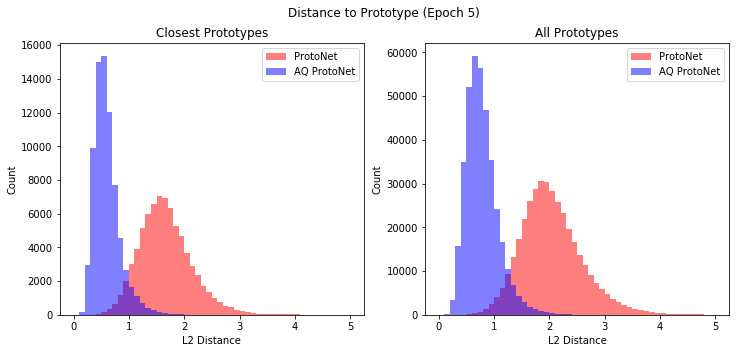

In [114]:
desired_range = (0,5) 
desired_bins = 50
suptitle = 'Distance to Prototype (Epoch 5)'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(suptitle)

ax1.hist(distance_to_proto, range=desired_range, bins=desired_bins, lw=3, fc=(1, 0, 0, 0.5), label='ProtoNet')
ax1.hist(distance_to_proto_adv, range=desired_range, bins=desired_bins, lw=3, fc=(0, 0, 1, 0.5), label='AQ ProtoNet') 
ax1.set_title('Closest Prototypes')
ax1.set(xlabel='L2 Distance', ylabel='Count')
ax1.legend(prop={'size': 10})

ax2.hist(distance_to_proto_all, range=desired_range, bins=desired_bins, lw=3, fc=(1, 0, 0, 0.5), label='ProtoNet')
ax2.hist(distance_to_proto_adv_all, range=desired_range, bins=desired_bins, lw=3, fc=(0, 0, 1, 0.5), label='AQ ProtoNet') 
ax2.set_title('All Prototypes')
ax2.set(xlabel='L2 Distance', ylabel='Count')
ax2.legend(prop={'size': 10})